In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = './'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

caffe.set_mode_cpu()
net = caffe.Classifier(caffe_root + 'object_pose_recognition/model/deploy.prototxt',
                caffe_root + 'object_pose_recognition/model/obe_clean_iter_25000.caffemodel',
                caffe.TEST)

blob = caffe.proto.caffe_pb2.BlobProto()
data = open( caffe_root + 'object_pose_recognition/model/obe_clean_mean.binaryproto' , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
out = arr[0]

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', out.mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
#transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

net.blobs['data'].reshape(1,3,64,64)
img = caffe.io.load_image(caffe_root + 'object_pose_recognition/model/image0916.png')
net.blobs['data'].data[...] = transformer.preprocess('data', img)


out = net.forward()

def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

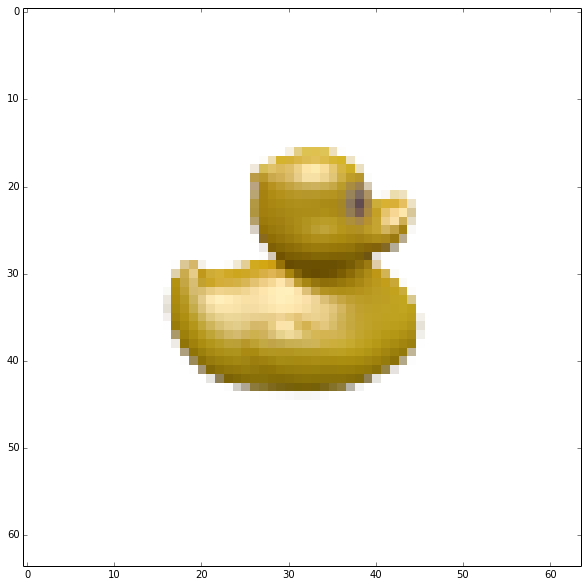

In [2]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [3]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 64, 64)),
 ('conv1_a', (1, 16, 56, 56)),
 ('pool1_a', (1, 16, 28, 28)),
 ('conv2_a', (1, 7, 24, 24)),
 ('pool2_a', (1, 7, 12, 12)),
 ('ip3_a', (1, 256)),
 ('ip4_a', (1, 16))]

In [4]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (16, 3, 9, 9)),
 ('conv2', (7, 16, 5, 5)),
 ('ip3_a', (256, 1008)),
 ('ip4_a', (16, 256))]

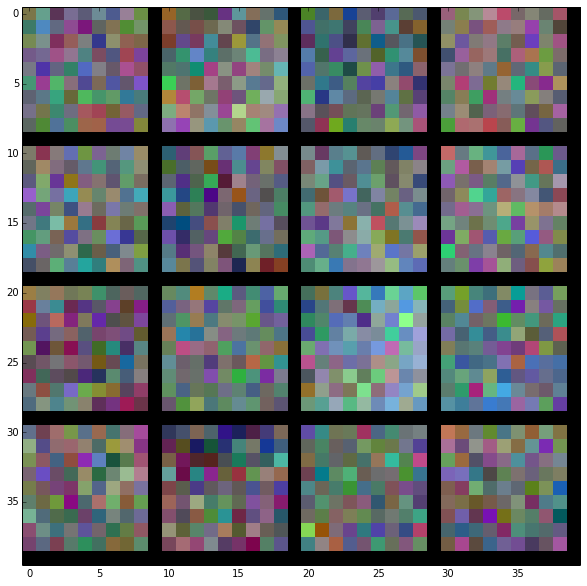

In [5]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

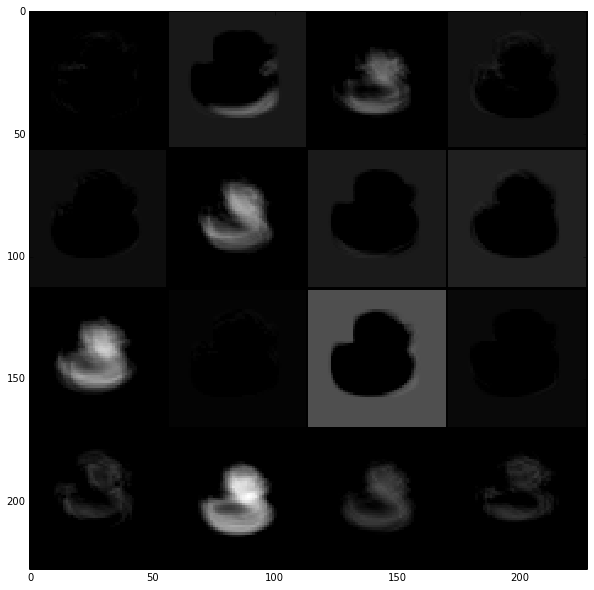

In [6]:
feat = net.blobs['conv1_a'].data[0]
vis_square(feat)

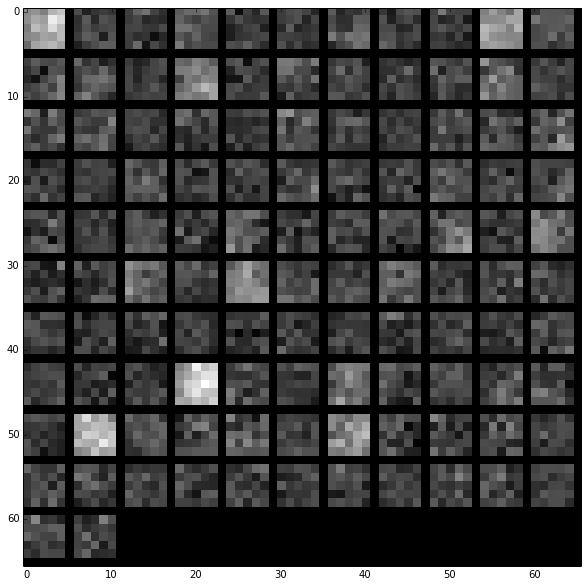

In [7]:
filters = net.params['conv2'][0].data
vis_square(filters.reshape(112, 5, 5))

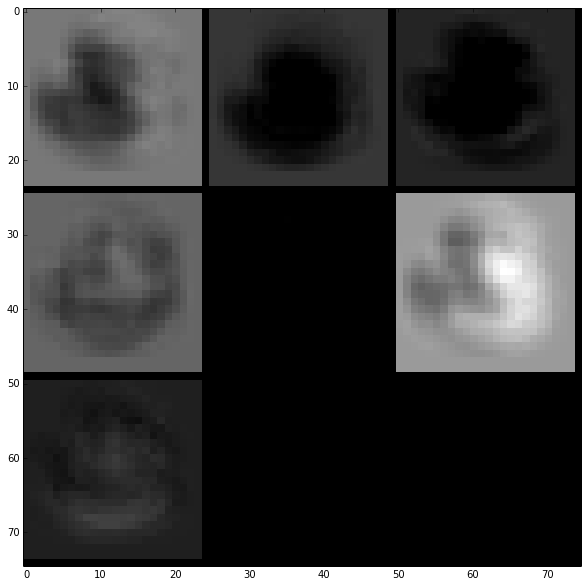

In [8]:
feat = net.blobs['conv2_a'].data[0, :36]
vis_square(feat)

In [9]:
print(format(out['ip4_a']))

[[  8.97042513e-01  -9.27417660e+00  -3.88623333e+00   3.60457230e+00
    8.46243858e-01   6.73730993e+00   1.95829463e+00   1.58031678e+00
    5.51934529e-04  -8.98383141e+00   6.86098635e-01  -1.50497049e-01
   -2.40931892e+00   5.68236637e+00   7.63157368e+00   1.66400790e+00]]
